# Lab 09: Word embeddings (2/2)

<br>

<img width=300 align="left" margin="20" src="number-matrix.jpg">
<img width=300 margin="20" src="wordgeom.png">

<br>

In this lab we will continue to work with word embeddings&mdash;machine learning algorithms that represent categorical data like words as vectors in a high dimensional space. 

Embeddings are constructed using cooccurrence statistics, and can be applied whenever you have "objects" that appear together&mdash;songs in playlists, words in documents, ingredients in recipes... Embeddings can reveal surprising semantic relations encoded in linear relationships; but they are "data hungry" and require large corpora of text or other coocurrence data to construct useful representations.

We will first explore how to visualize the embedding vectors. Perhaps confusingly, this is done by embedding the embedding vectors themselves into two dimensions. The most 
popular method for doing this is called t-SNE ("TEE snee"). [Here](https://lvdmaaten.github.io/tsne/) is an overview of t-SNE by its creator, and [here](http://cs.stanford.edu/people/karpathy/tsnejs/) is an introduction that includes some (potentially) interesting examples. We will then explore ways in which embeddings may represent certain "cultural biases," which has been a topic of recent interest in the machine learning and AI communities.

Let's begin by loading in the 100-dimensional GloVe embeddings we worked with last time. Recall that these are trained using word cooccurrence counts from about 6 billion words of text from Wikipedia pages.

In [1]:
import gensim
import gensim.downloader as gdl
from gensim.models import KeyedVectors
glove = gdl.load("glove-wiki-gigaword-100")

Next we'll import the usual modules, and in addition a module that implements t-SNE.

In [2]:
from datascience import *
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline

We'll now define two functions. The first takes a pre-trained embedding model, together with a vocabulary of words (as strings), which is a subset of the words in the embedding vocabulary. It then runs t-SNE on that vocabulary, displaying the results as a point cloud. The second function displays the location of particular words, so that we can get a sense of the geometry of the embeddings, and what's close to what.

In [3]:

def generate_tsne_for_voc(model, voc):
    word_list = [w for w in model.vocab]
    w = word_list[0]
    dim = len(model[w])
    print("embedding dimension: %d" % dim)
    print("computing t-SNE vectors over %d words..." % len(voc))
    
    # collect all the vectors in a list
    arr = np.empty((0,dim), dtype='f')
    for w in voc:
        wrd_vector = model[w]
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    # display scatter plot of the 2-d vectors
    plt.figure(figsize=(15,15))    
    plt.scatter(Y[:,0], Y[:,1], s=2)
    plt.show()
    return (Y,voc)


# this function displays the "word cloud" of all points from the t-SNE vectors,
# and then labels the words in the array input_words

def display_tsne_words(Z, input_words, size1=2, size2=50, offset=5):
    Y = Z[0]
    voc = Z[1]
    x_coord = Y[:, 0]
    y_coord = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(15,15))
    plt.scatter(x_coord, y_coord, s=size1)
    for w in np.arange(len(input_words)):
        index = voc.index(input_words[w])
        plt.scatter(x_coord[index], y_coord[index],s=size2)
        plt.annotate(input_words[w], xy=(x_coord[index],y_coord[index]), \
                     xytext=(offset,offset), textcoords='offset points')
    plt.show()
    


The following bit of code computes word frequencies. We read in the 'text8' dataset from last lab, which you'll recall is a few million words of Wikipedia text. We then build a vocabulary over this data using the `Counter` class.

In [4]:
from collections import Counter
import time
import nltk

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.root.level = logging.CRITICAL 

s = time.time()
voc = Counter()
for rec in open ('../lab08/text8', 'r'):
    rec = rec.strip()
    voc.update(rec.split())
print(time.time()-s)

5.195571184158325


Now we grab the most common words, excluding the top (say) 100.

In [5]:
n = 5000
words = voc.most_common(n+100)[100:]
vocab = [word[0] for word in words]
len(vocab)

5000

Finally, we run t-SNE on the GloVe embeddings, but restricting to this subset of the model vocabulary. This is only for speed and memory considerations.

embedding dimension: 100
computing t-SNE vectors over 4998 words...


<Figure size 1080x1080 with 0 Axes>

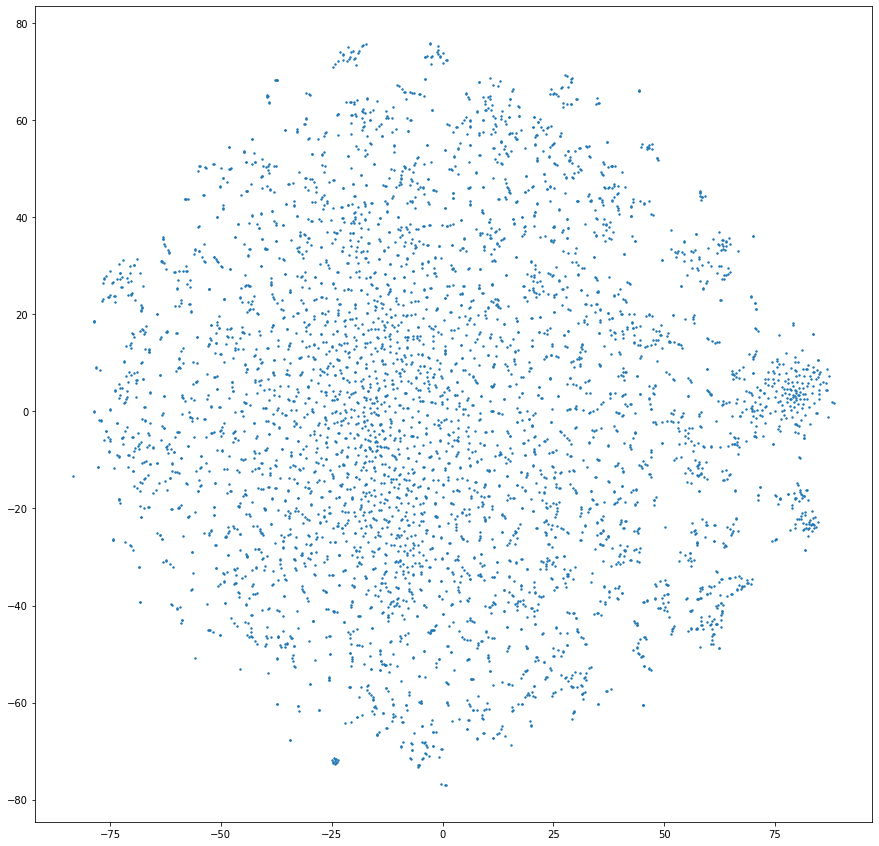

CPU times: user 3min 8s, sys: 146 ms, total: 3min 9s
Wall time: 22 s


In [6]:
%%time
filtered_voc = [w for w in vocab if w in glove.vocab]
len(filtered_voc)
plt.figure(figsize=(15,15))
Z = generate_tsne_for_voc(glove, filtered_voc)

Now, we display some words by labeling points in the t-SNE embeddings.

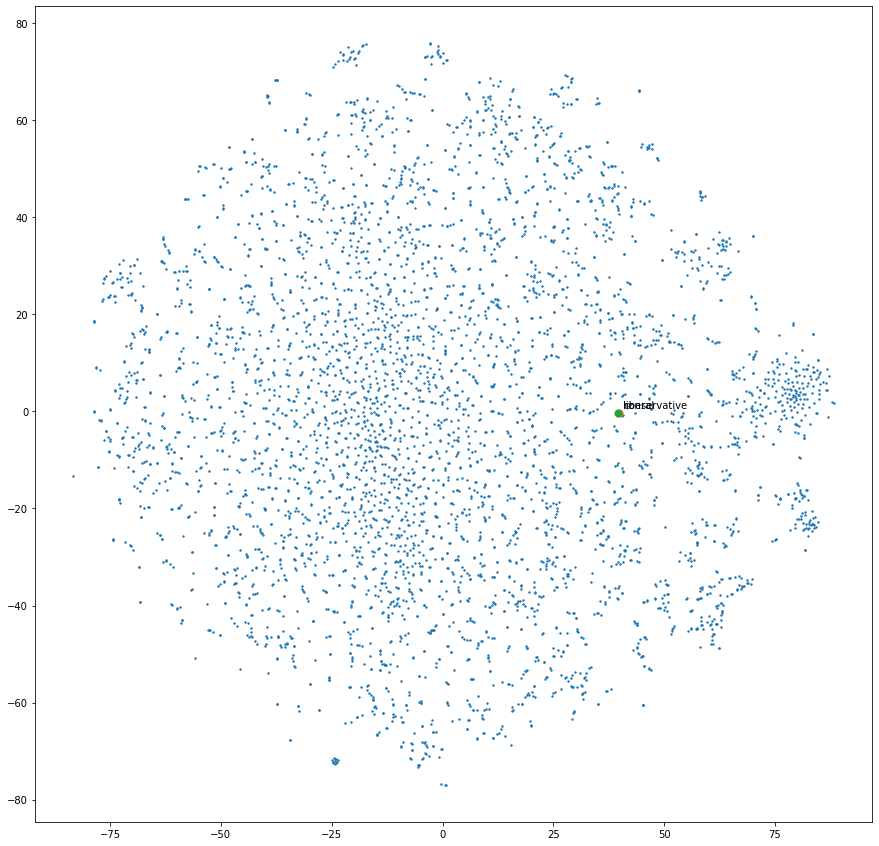

In [7]:
display_tsne_words(Z, input_words=['conservative', 'liberal'])

### Your turn!

Using the functions defined above, generate several plots show locations of points you choose. Generate a plot, and then describe in a markdown cell why this either makes sense or is puzzling to you. For example, you might find that "apple" is not near "fruit" but is rather close to "ibm." This should be easy to explain. Find others and comment on what you see.

To start, first generate t-SNE vectors for a larger subset of the 400,000 model vocabulary. You might use something like `n=10000`.

embedding dimension: 100
computing t-SNE vectors over 19939 words...


<Figure size 1080x1080 with 0 Axes>

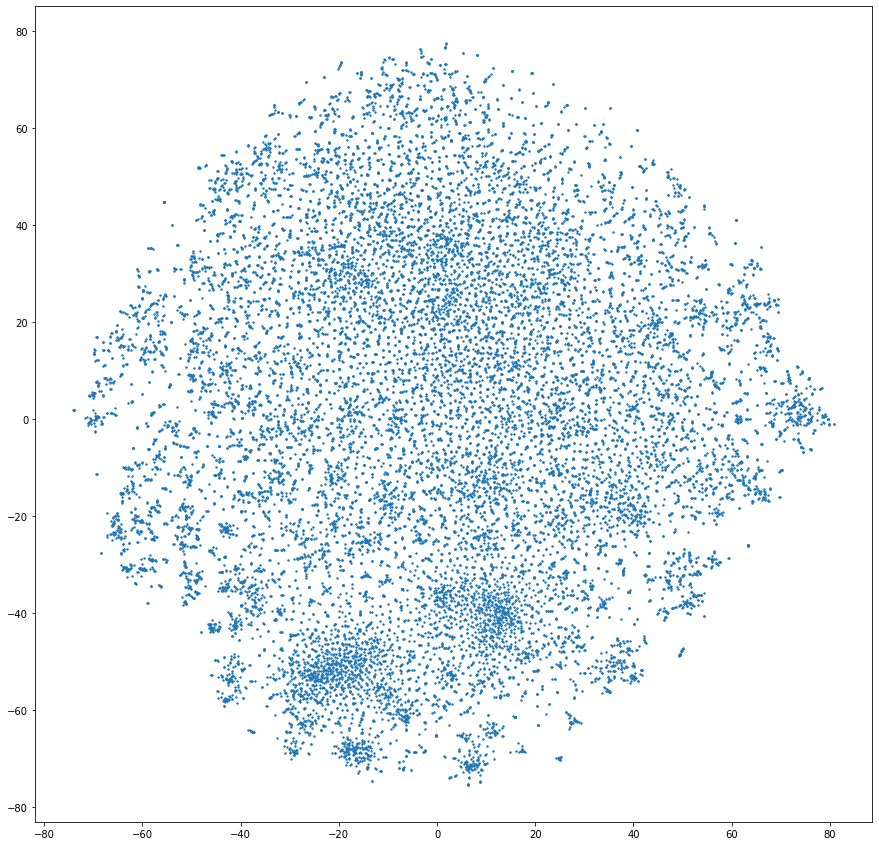

In [8]:
n = 20000
words = voc.most_common(n+100)[100:]
vocab = [word[0] for word in words]
filtered_voc = [w for w in vocab if w in glove.vocab]
len(filtered_voc)
plt.figure(figsize=(15,15))
Z = generate_tsne_for_voc(glove, filtered_voc)

### Cultural bias in embeddings

Embeddings are used in an increasing number of AI and machine learning applications. For example, they are used in placing ads at Facebook, recommending entertainment, and they form the first layer of deep neural networks for many prediction tasks. 

Recently there has been attention paid to "bias" in embeddings. To minimize confusion with statistical terminology, let's refer to this as "cultural bias." Here are pointers to recent literature on this topic: [paper 1](https://arxiv.org/abs/1607.06520), [paper 2](https://arxiv.org/abs/1810.03611), [some code](https://github.com/tolga-b/debiaswe). And here is an interactive site that allows you to explore [gender bias in embeddings](http://wordbias.umiacs.umd.edu/#). Here is a site that investigates [racial bias in embeddings](http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/). 

In this portion of the lab, we will make a first foray into cultural bias in embeddings. To begin, let's consider two analogies. `Scientist is to man as ? is to woman` and `Scientist is to woman as ? is to man`.  So, we're exploring the implicit "maleness" and "femaleness" of the embedding dimensions of the word "scientist". Recall how we compute these analogies:


In [9]:
import warnings
warnings.filterwarnings("ignore",category=Warning)

glove.most_similar(positive=['scientist', 'woman'], negative=['man'])

[('researcher', 0.7770122289657593),
 ('anthropologist', 0.6847511529922485),
 ('sociologist', 0.6701031923294067),
 ('psychologist', 0.6586965918540955),
 ('physicist', 0.6574066281318665),
 ('professor', 0.6503505706787109),
 ('biologist', 0.6430926322937012),
 ('geneticist', 0.6415170431137085),
 ('biochemist', 0.6236249804496765),
 ('expert', 0.6134213209152222)]

In [10]:
glove.most_similar(positive=['scientist', 'man'], negative=['woman'])

[('physicist', 0.712790846824646),
 ('expert', 0.6874810457229614),
 ('biologist', 0.6378966569900513),
 ('professor', 0.631798267364502),
 ('researcher', 0.6256967186927795),
 ('geologist', 0.5929147601127625),
 ('engineer', 0.5864611864089966),
 ('astronomer', 0.5833232402801514),
 ('science', 0.5784966349601746),
 ('mathematician', 0.5764097571372986)]

Here is a little function that extracts the top ten words from an analogy.

In [11]:
def analogy(pos_words, neg_words):
    results = glove.most_similar(positive=pos_words, negative=neg_words)
    words = [result[0] for result in results]
    return words
    
print(analogy(['scientist', 'woman'], ['man']))
print(analogy(['scientist', 'man'], ['woman']))


['researcher', 'anthropologist', 'sociologist', 'psychologist', 'physicist', 'professor', 'biologist', 'geneticist', 'biochemist', 'expert']
['physicist', 'expert', 'biologist', 'professor', 'researcher', 'geologist', 'engineer', 'astronomer', 'science', 'mathematician']


### Your turn

Write a function `show_analogy_difference` that takes three words, and runs the analogy with the order of the last two words in different orders. The result is a table with two columns for each of these words. For example, the analogies above would give us this table:


In [12]:
Table().with_columns('scientist-woman+man', \
                     ['physicist', 'expert', 'biologist', 'professor', 'researcher', 'geologist', 'engineer', 'astronomer', 'science', 'mathematician'], \
                     'scientist+man-woman', \
                     ['researcher', 'anthropologist', 'sociologist', 'psychologist', 'physicist', 'professor', 'biologist', 'geneticist', 'biochemist', 'expert'])

scientist-woman+man,scientist+man-woman
physicist,researcher
expert,anthropologist
biologist,sociologist
professor,psychologist
researcher,physicist
geologist,professor
engineer,biologist
astronomer,geneticist
science,biochemist
mathematician,expert


Write the function `show_analogy_difference` that would construct such a table for an arbitrary pair. Show the results for several different triples, with an eye toward locating interesting examples of "cultural bias" in the embeddings. Comment on your findings in markdown cells.

In [13]:
def show_analogy_difference(a='scientist', b='woman', c='man') :
    first = analogy([a, b], [c])
    second = analogy([a, c], [b])
    return Table().with_columns('{} - {} + {}'.format(a, b, c), first, '{} - {} + {}'.format(a, c, b), second)

In [14]:
show_analogy_difference()

scientist - woman + man,scientist - man + woman
researcher,physicist
anthropologist,expert
sociologist,biologist
psychologist,professor
physicist,researcher
professor,geologist
biologist,engineer
geneticist,astronomer
biochemist,science
expert,mathematician
